In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from scipy import sparse
from sklearn.decomposition import PCA

In [3]:
df_18 = pd.read_csv('../Data/Patent data - PatentsView/subset_post_2018.csv')
df_18 = df_18.drop(['kind','filename','withdrawn'],axis=1)
len(df_18)


search_terms = ['network','memory','vehicle','lens','display']
df_18['subset'] = 'other'
for term in search_terms:
    df_18.loc[[term in x for x in df_18.abstract],'subset'] = term

    
n_values = 10_000
total_length = len(df_18)
print('total_length:',total_length)
df_18 = df_18[~(df_18.subset=='other')]
df_18 = df_18.iloc[::len(df_18)//n_values]
print('length after shortening', len(df_18))

C:\Users\Sverrir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


total_length: 534814
length after shortening 10640


In [4]:
df_18.subset.value_counts()

display    3548
network    2570
vehicle    2162
memory     1760
lens        600
Name: subset, dtype: int64

In [5]:
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import Stemmer
english_stemmer = Stemmer.Stemmer('en')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))
    



In [6]:
def docs_to_vecs(sub_df,additioinal_stop_words = []):
    new_stop_words = [x for x in ENGLISH_STOP_WORDS] 
    [new_stop_words.append(x) for x in additioinal_stop_words]
    vectorizer = StemmedTfidfVectorizer(max_df=0.95,min_df=2, stop_words=new_stop_words)
    X = vectorizer.fit_transform(sub_df.abstract)
    
    return X

def Vecs_to_Sim_matrix(X):
    # Create similarity matrix
    # Erum með sparse matrix, viljum optimizea fyrir það. 
    Sim_matrix = cosine_similarity(X)
    print('cosine similarity done')
    # Diagonal = 0
    
    np.fill_diagonal(Sim_matrix,0)
    print('diagonal')
    # Normalize to sum = 1
    Sim_matrix = normalize(Sim_matrix)
    print('normalized')
    
    return Sim_matrix

def get_coords(sub_df,X_emb):
    sub_df['x'] = X_emb[:,0]
    sub_df['y'] = X_emb[:,1]
    return sub_df

In [7]:
X = docs_to_vecs(df_18) # runtime: ~1-2minutes  
print(X.shape) #- output: (534814, 45665)
print('doc to vec done')

(10640, 5802)
doc to vec done


In [8]:
#Check if the matrix is sparse
from scipy.sparse import issparse
issparse(X)


True

In [9]:
Sim_matrix = Vecs_to_Sim_matrix(X) # Runtime can be long for large sets

cosine similarity done
diagonal
normalized


In [10]:
# Milli 10 og 20 k, þá fyllist RAM...
# Prófa að nota PCA á undan

tsne = TSNE(n_components=2,n_jobs=-1,verbose=2,metric='cosine',angle=1,random_state=42)
X_embedded = tsne.fit_transform(Sim_matrix)
df_18 = get_coords(df_18,X_embedded)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10640 samples in 0.142s...
[t-SNE] Computed neighbors for 10640 samples in 51.815s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10640
[t-SNE] Computed conditional probabilities for sample 2000 / 10640
[t-SNE] Computed conditional probabilities for sample 3000 / 10640
[t-SNE] Computed conditional probabilities for sample 4000 / 10640
[t-SNE] Computed conditional probabilities for sample 5000 / 10640
[t-SNE] Computed conditional probabilities for sample 6000 / 10640
[t-SNE] Computed conditional probabilities for sample 7000 / 10640
[t-SNE] Computed conditional probabilities for sample 8000 / 10640
[t-SNE] Computed conditional probabilities for sample 9000 / 10640
[t-SNE] Computed conditional probabilities for sample 10000 / 10640
[t-SNE] Computed conditional probabilities for sample 10640 / 10640
[t-SNE] Mean sigma: 0.149124
[t-SNE] Computed conditional probabilities in 0.585s
[t-SNE] Iteration 50: error = 95.85

display    3548
network    2570
vehicle    2162
memory     1760
lens        600
Name: subset, dtype: int64


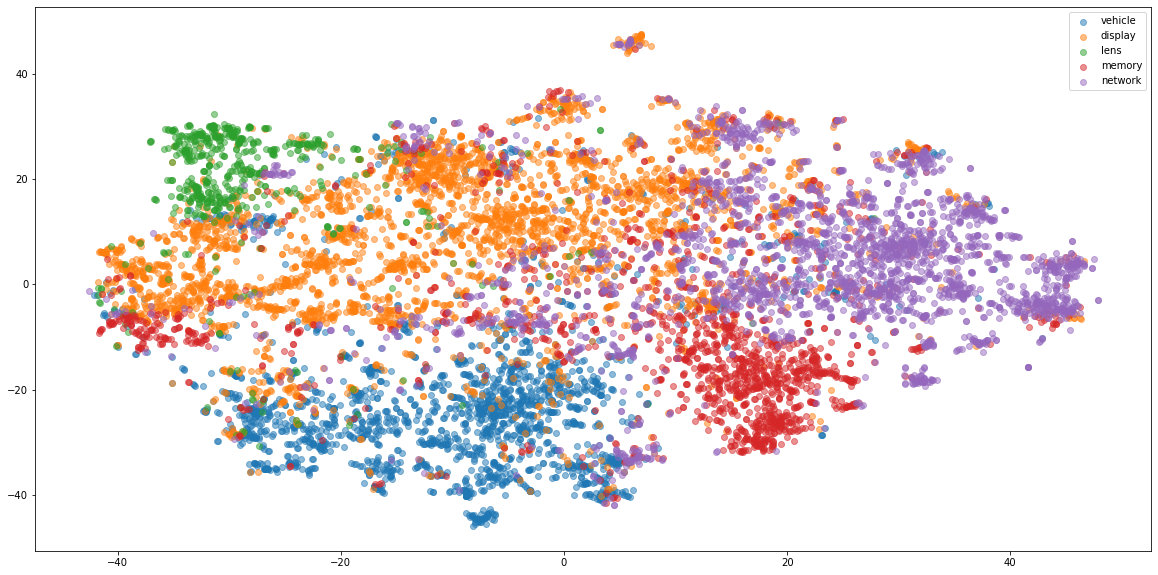

In [11]:

print(df_18.subset.value_counts())
#Plot

plt.figure(figsize=(20,10))
for u_word in df_18['subset'].unique():
    plt.scatter(df_18[[x == u_word for x in df_18['subset']]]['x'],
                df_18[[x == u_word for x in df_18['subset']]]['y'],alpha=0.5)
    
plt.legend(df_18['subset'].unique())
plt.show()

In [12]:
# Milli 10 og 20 k, þá fyllist RAM...
# Prófa að nota PCA á undan

pca_n_comp = 100
new_input = PCA(n_components=pca_n_comp).fit_transform(Sim_matrix)
print('PCA')
tsne = TSNE(n_components=2,n_jobs=-1,verbose=2,metric='cosine',angle=1,random_state=42)
X_embedded = tsne.fit_transform(new_input)
df_18 = get_coords(df_18,X_embedded)

PCA
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10640 samples in 0.002s...
[t-SNE] Computed neighbors for 10640 samples in 5.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10640
[t-SNE] Computed conditional probabilities for sample 2000 / 10640
[t-SNE] Computed conditional probabilities for sample 3000 / 10640
[t-SNE] Computed conditional probabilities for sample 4000 / 10640
[t-SNE] Computed conditional probabilities for sample 5000 / 10640
[t-SNE] Computed conditional probabilities for sample 6000 / 10640
[t-SNE] Computed conditional probabilities for sample 7000 / 10640
[t-SNE] Computed conditional probabilities for sample 8000 / 10640
[t-SNE] Computed conditional probabilities for sample 9000 / 10640
[t-SNE] Computed conditional probabilities for sample 10000 / 10640
[t-SNE] Computed conditional probabilities for sample 10640 / 10640
[t-SNE] Mean sigma: 0.191983
[t-SNE] Computed conditional probabilities in 0.718s
[t-SNE] Iteration 50: error = 96

In [13]:

print(len(df_18))
print(len(X_embedded))

10640
10640


display    3548
network    2570
vehicle    2162
memory     1760
lens        600
Name: subset, dtype: int64


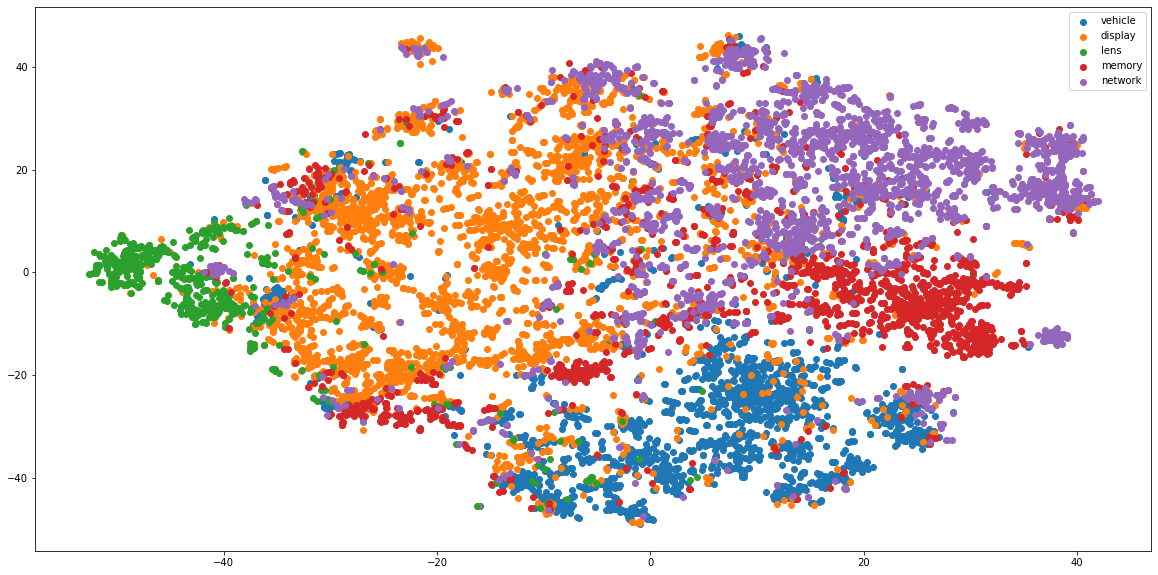

In [14]:

print(df_18.subset.value_counts())
#Plot

plt.figure(figsize=(20,10))
for u_word in df_18['subset'].unique():
    plt.scatter(df_18[[x == u_word for x in df_18['subset']]]['x'],
                df_18[[x == u_word for x in df_18['subset']]]['y'])
    
plt.legend(df_18['subset'].unique())
plt.show()

In [15]:
# %matplotlib inline
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

sub_df_18 = df_18
fig, ax = plt.subplots(1,1,figsize=(15,8))
N = 100

scatter = ax.scatter(x = sub_df_18['x'],
                     y = sub_df_18['y'],
                     alpha=0.3)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = [i for i in sub_df_18['title']]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()

<IPython.core.display.Javascript object>


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [10/Jan/2020 15:22:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Jan/2020 15:22:13] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Jan/2020 15:22:13] "GET /mpld3.js HTTP/1.1" 200 -


In [17]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

sub_df_18 = df_18.iloc[::100]

x = sub_df_18['x']/120
y = sub_df_18['y']/120
names = sub_df_18['title']


fig,ax = plt.subplots()
sc = plt.scatter(x,y, s=100, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(True)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

<IPython.core.display.Javascript object>

NameError: name 'norm' is not defined